# Design criteria
We want a 2D model system we can use for illustration, and also to weed out ideas that are definitely bad...


* Should have a lot of obvious metastable states, with a lot of "microstates" within each "macrostate"...
* Should have a mix of entropic and energetic barriers
* Should have interesting differences between what works for over-damped (diffusive) vs. under-damped (ballistic) kinetics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_egg_crate_landscape(well_frequency=6.0,
                                 well_depth=5.0,
                                 background_roughness_frequency=20.0,
                                 background_depth=1.0,
                                ):
    """Rough energy landscape, with ~ 16 big wells and a lot of little wells"""
    def U(x):
        background = background_depth * np.sum(np.sin(x * background_roughness_frequency))
        wells = well_depth * np.sum(np.sin(x * well_frequency))
        
        return background + wells + np.sum((x)**4)
    
    def dU(x):
        background = background_depth * background_roughness_frequency * (np.cos(x * background_roughness_frequency))
        wells = well_depth * well_frequency * (np.cos(x * well_frequency))
        
        return background + wells + (4 * (x**3))
                       
    return U, dU

In [3]:
np.random.seed(2)
U, dU = generate_egg_crate_landscape()

In [4]:
from numba import jit

In [5]:
@jit
def force(x):
    return -dU(x)

In [6]:
def langevin_factory(force):
    @jit
    def simulate_langevin(x, v, stepsize=0.01, collision_rate=0.01, n_steps=1000, mass=1.0, temperature=1.0):
    
        dim = len(x)

        xs = np.zeros((n_steps, dim))

        a = np.exp(-collision_rate * stepsize)
        b = np.sqrt(1 - np.exp(-2 * collision_rate * stepsize))

        sigma_O = np.sqrt(temperature / mass)

        f = force(x)
        
        maxwell_boltzmann = sigma_O * np.random.randn(n_steps, dim)

        for i in range(n_steps):

            # V
            v += (stepsize / 2) * f / mass
            # R
            x += (stepsize / 2) * v
            # O
            v = a * v + b * maxwell_boltzmann[i]
            # R
            x += (stepsize / 2) * v
            f = force(x)
            # V
            v += (stepsize / 2) * f / mass

            xs[i] = x

        return xs
    return simulate_langevin

In [7]:
simulate_langevin = langevin_factory(force)

In [8]:
from itertools import product
maxima_1d = np.pi / 12 * np.array([5, 1, -3, -7]) + (np.pi / 6)
initial_conditions = np.array(list(product(maxima_1d, repeat=2)))
initial_conditions

array([[ 1.83259571,  1.83259571],
       [ 1.83259571,  0.78539816],
       [ 1.83259571, -0.26179939],
       [ 1.83259571, -1.30899694],
       [ 0.78539816,  1.83259571],
       [ 0.78539816,  0.78539816],
       [ 0.78539816, -0.26179939],
       [ 0.78539816, -1.30899694],
       [-0.26179939,  1.83259571],
       [-0.26179939,  0.78539816],
       [-0.26179939, -0.26179939],
       [-0.26179939, -1.30899694],
       [-1.30899694,  1.83259571],
       [-1.30899694,  0.78539816],
       [-1.30899694, -0.26179939],
       [-1.30899694, -1.30899694]])

In [9]:
np.random.seed(0)

In [10]:
# run a few steps just to get it to JIT compile
_ = simulate_langevin(np.random.randn(2), np.random.randn(2), n_steps=10)

In [17]:
np.random.seed(10)
initial_x1 = np.random.randn(2)
initial_x2 = np.random.randn(2)
initial_v1 = np.random.randn(2)
initial_v2 = np.random.randn(2)

In [25]:
np.random.seed(0)
xs1 = simulate_langevin(initial_x1, initial_v1, n_steps=10000)

In [26]:
np.random.seed(0)
xs2 = simulate_langevin(initial_x2, initial_v2, n_steps=10000)

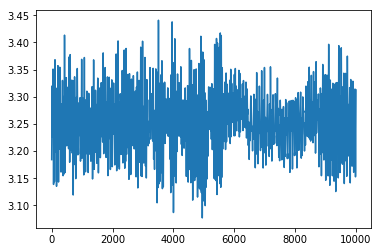

In [28]:
plt.plot(np.linalg.norm(xs2 - xs1, axis=1))

In [11]:
%%time
simulate_langevin(np.random.randn(2), np.random.randn(2), n_steps=10000)

CPU times: user 284 ms, sys: 11.5 ms, total: 296 ms
Wall time: 287 ms


array([[ 2.26708118, -1.45368243],
       [ 2.25791836, -1.44795638],
       [ 2.24166314, -1.43735968],
       ...,
       [-1.07372906, -1.25862358],
       [-1.10790754, -1.26013815],
       [-1.14237224, -1.26363816]])

In [12]:
from tqdm import tqdm

n_clones = 50

overdamped_trajs = []

for i in tqdm(range(len(initial_conditions))):
    x0 = np.array(initial_conditions[i])
    for _ in range(n_clones):
        xs = simulate_langevin(x0, np.random.randn(2), stepsize=0.05, collision_rate=np.inf, n_steps=10000)
        overdamped_trajs.append(xs)

100%|██████████| 16/16 [03:41<00:00, 14.46s/it]


In [13]:
underdamped_trajs = []

for i in tqdm(range(len(initial_conditions))):
    x0 = np.array(initial_conditions[i])
    for _ in range(n_clones):
        xs = simulate_langevin(x0, np.random.randn(2), stepsize=0.05, collision_rate=1.0, n_steps=10000)
        underdamped_trajs.append(xs)

100%|██████████| 16/16 [03:42<00:00, 12.99s/it]


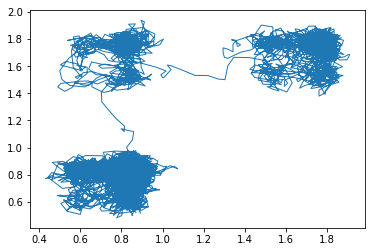

In [14]:
xs = overdamped_trajs[0]
plt.plot(xs[:,0], xs[:,1], linewidth=1, label='overdamped')

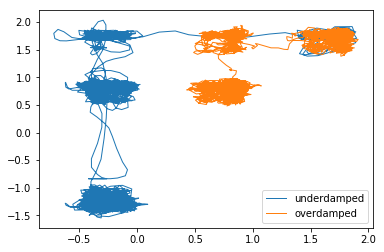

In [15]:
xs = underdamped_trajs[0]
plt.plot(xs[:,0], xs[:,1], linewidth=1, label='underdamped')

xs = overdamped_trajs[0]
plt.plot(xs[:,0], xs[:,1], linewidth=1, label='overdamped')

plt.legend(loc='best')

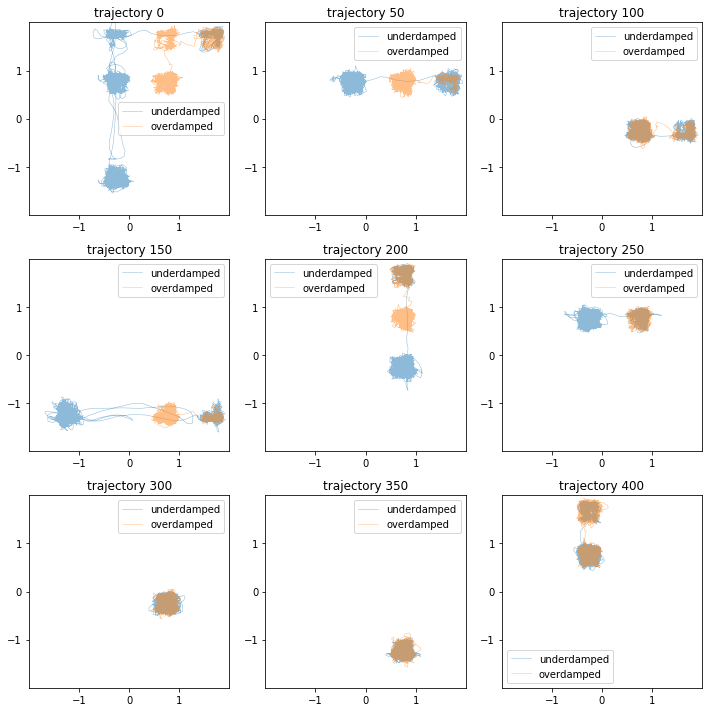

In [16]:
np.random.seed(1)
plt.figure(figsize=(10,10))

n_rows = n_cols = 3

for i in range(n_rows * n_cols):
    ind = 50 * i
    plt.subplot(n_rows, n_cols, i + 1)
    
    xs = underdamped_trajs[ind]
    plt.plot(xs[:,0], xs[:,1], linewidth=0.5, alpha=0.5, label='underdamped')

    xs = overdamped_trajs[ind]
    plt.plot(xs[:,0], xs[:,1], linewidth=0.5, alpha=0.5, label='overdamped')
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.legend(loc='best')
    plt.title('trajectory {}'.format(ind))
    plt.xticks([-1,0,1])
    plt.yticks([-1,0,1])
plt.tight_layout()

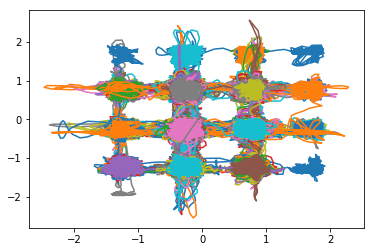

In [17]:
for xs in underdamped_trajs:
    plt.plot(xs[:,0], xs[:,1])

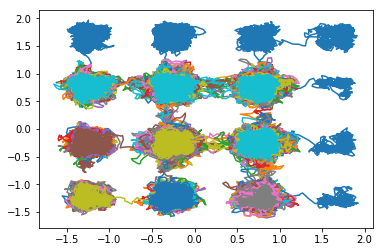

In [18]:
for xs in overdamped_trajs:
    plt.plot(xs[:,0], xs[:,1])

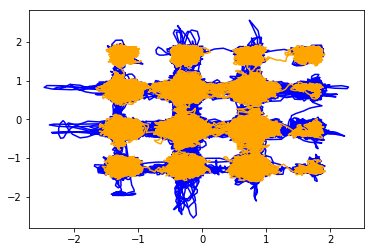

In [19]:
for xs in underdamped_trajs:
    plt.plot(xs[:,0], xs[:,1], color='blue')
    
for xs in overdamped_trajs:
    plt.plot(xs[:,0], xs[:,1], color='orange')

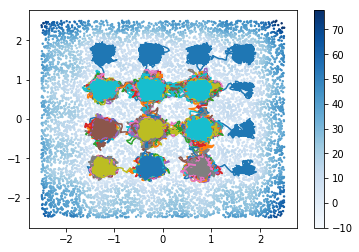

In [20]:
for xs in overdamped_trajs:
    plt.plot(xs[:,0], xs[:,1])
width = 5
X = np.random.rand(10000, 2) * width - (0.5 * width)
Us = np.array([U(x) for x in X])
plt.scatter(X[:,0], X[:,1], c=Us, s=2, cmap='Blues')
plt.colorbar()

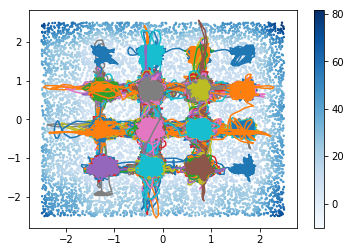

In [21]:
for xs in underdamped_trajs:
    plt.plot(xs[:,0], xs[:,1])

X = np.random.rand(10000, 2) * width - (0.5 * width)
Us = np.array([U(x) for x in X])
plt.scatter(X[:,0], X[:,1], c=Us, s=2, cmap='Blues')
plt.colorbar()

In [22]:
from msmbuilder.cluster import RegularSpatial

clust = RegularSpatial(d_min=0.15)
clust.fit([xs[::10] for xs in overdamped_trajs])

/Users/joshuafass/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/joshuafass/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas

RegularSpatial(d_min=0.15, metric='euclidean')

In [23]:
len(clust.cluster_centers_)

209

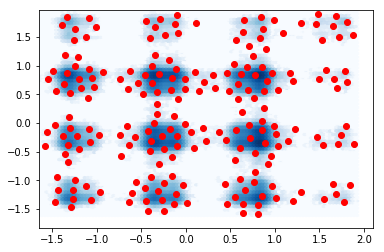

In [24]:
X = np.vstack(overdamped_trajs)
plt.hexbin(X[:,0], X[:,1], bins='log', cmap='Blues')
plt.scatter(*clust.cluster_centers_.T, color='red')

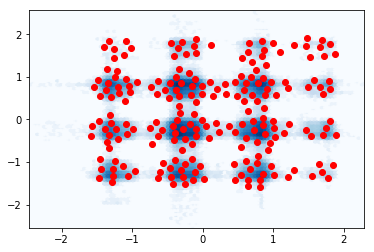

In [25]:
X = np.vstack(underdamped_trajs)
plt.hexbin(X[:,0], X[:,1], bins='log', cmap='Blues')
plt.scatter(*clust.cluster_centers_.T, color='red')

In [26]:
underdamped_dtrajs = clust.predict(underdamped_trajs)

In [27]:
overdamped_dtrajs = clust.predict(overdamped_trajs)

In [28]:
import pyemma
overdamped_msm = pyemma.msm.estimate_markov_model(overdamped_dtrajs, lag=10)
overdamped_msm.active_count_fraction

0.946916125

In [29]:
underdamped_msm = pyemma.msm.estimate_markov_model(underdamped_dtrajs, lag=10)
underdamped_msm.active_count_fraction

0.999907

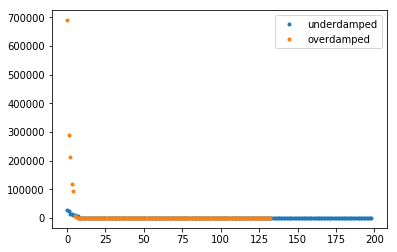

In [30]:
plt.plot(underdamped_msm.timescales(), '.', label='underdamped')
plt.plot(overdamped_msm.timescales(), '.', label='overdamped')
plt.legend(loc='best')

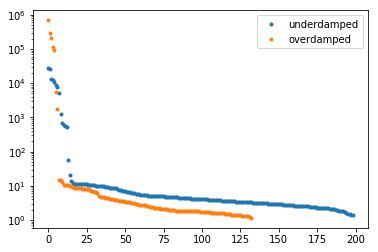

In [31]:
plt.plot(underdamped_msm.timescales(), '.', label='underdamped')
plt.plot(overdamped_msm.timescales(), '.', label='overdamped')
plt.legend(loc='best')
plt.yscale('log')

In [32]:
max(overdamped_msm.timescales()) / max(underdamped_msm.timescales())

25.687205652381017

In [33]:
int(max(overdamped_msm.timescales())), int(max(underdamped_msm.timescales()))

(690291, 26872)

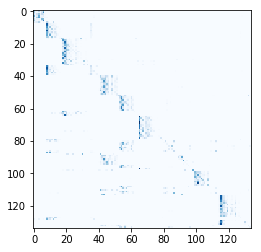

In [34]:
plt.imshow(overdamped_msm.P, cmap='Blues')

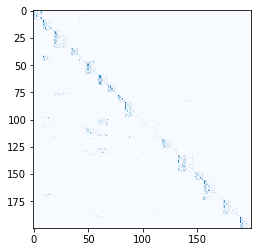

In [35]:
plt.imshow(underdamped_msm.P, cmap='Blues')

In [36]:
len(overdamped_dtrajs)

800

In [37]:
from scipy.spatial.distance import cdist
def ground_truth_discretization(xs):
    return np.argmin(cdist(xs, initial_conditions), 1)

In [38]:
overdamped_dtrajs_gt = [ground_truth_discretization(xs) for xs in overdamped_trajs]
underdamped_dtrajs_gt = [ground_truth_discretization(xs) for xs in underdamped_trajs]

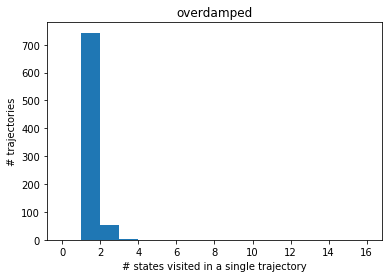

In [39]:
sets = [set(x) for x in overdamped_dtrajs_gt]
n_states = list(map(len, sets))
total_n_states = len(set.union(*sets))
plt.hist(n_states, bins=np.arange(1 + total_n_states))
plt.xlabel('# states visited in a single trajectory')
plt.ylabel('# trajectories')
plt.title('overdamped')

In [40]:
# let's bootstrap over the trajectories and see how quickly we visit all states

cumulative_states_visited = []

n_bootstrapped_samples = 100
for _ in tqdm(range(n_bootstrapped_samples)):
    inds = np.random.randint(0, len(sets), len(sets))
    re_ordered_sets = [sets[i] for i in inds]
    cumulative_states_visited.append(np.array([len(set.union(*re_ordered_sets[:i])) for i in range(1, len(sets))]))

100%|██████████| 100/100 [00:02<00:00, 44.95it/s]


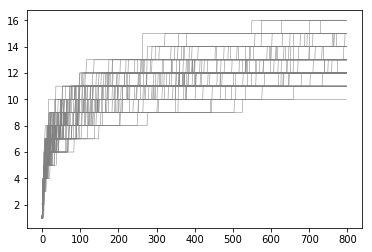

In [41]:
for curve in cumulative_states_visited:
    plt.plot(curve, color='grey', linewidth=0.5)

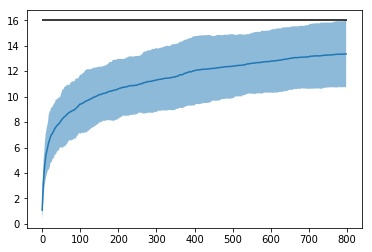

In [42]:
mean = np.mean(cumulative_states_visited, 0)
stdev = np.std(cumulative_states_visited, 0)

plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean - 2 * stdev, np.minimum(total_n_states, mean + 2 * stdev), alpha=0.5)
plt.hlines(total_n_states, 0,  len(cumulative_states_visited[0]))

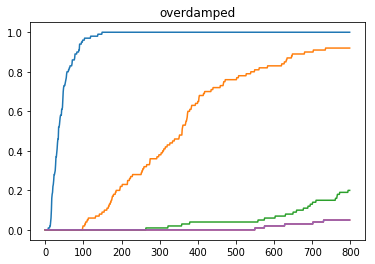

In [43]:
plt.plot((np.array(cumulative_states_visited) >= 0.50 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.75 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.90 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.95 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.99 * total_n_states).mean(0))

plt.title('overdamped')

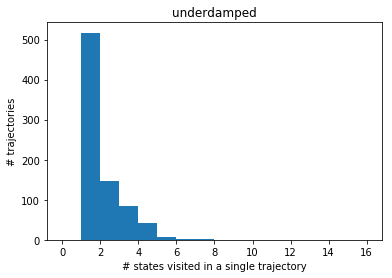

In [44]:
sets = [set(x) for x in underdamped_dtrajs_gt]
n_states = list(map(len, sets))
total_n_states = len(set.union(*sets))
plt.hist(n_states, bins=np.arange(1 + total_n_states))
plt.xlabel('# states visited in a single trajectory')
plt.ylabel('# trajectories')
plt.title('underdamped')

In [45]:
# let's bootstrap over the trajectories and see how quickly we visit all states

cumulative_states_visited = []

n_bootstrapped_samples = 100
for _ in tqdm(range(n_bootstrapped_samples)):
    inds = np.random.randint(0, len(sets), len(sets))
    re_ordered_sets = [sets[i] for i in inds]
    cumulative_states_visited.append(np.array([len(set.union(*re_ordered_sets[:i])) for i in range(1, len(sets))]))

100%|██████████| 100/100 [00:03<00:00, 32.75it/s]


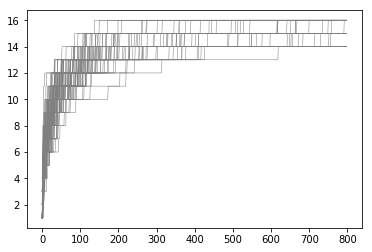

In [46]:
for curve in cumulative_states_visited:
    plt.plot(curve, color='grey', linewidth=0.5)

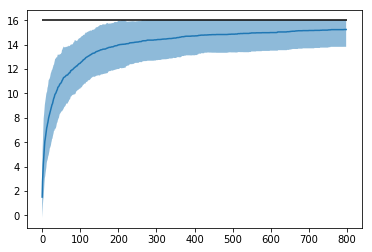

In [47]:
mean = np.mean(cumulative_states_visited, 0)
stdev = np.std(cumulative_states_visited, 0)

plt.plot(mean)
plt.fill_between(np.arange(len(mean)), mean - 2 * stdev, np.minimum(total_n_states, mean + 2 * stdev), alpha=0.5)
plt.hlines(total_n_states, 0,  len(cumulative_states_visited[0]))

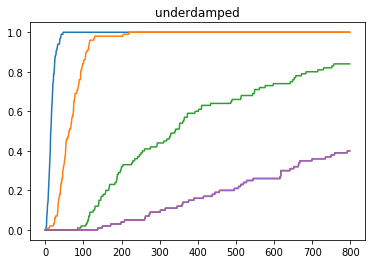

In [48]:
plt.plot((np.array(cumulative_states_visited) >= 0.50 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.75 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.90 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.95 * total_n_states).mean(0))
plt.plot((np.array(cumulative_states_visited) >= 0.99 * total_n_states).mean(0))

plt.title('underdamped')

In [49]:
overdamped_msm_gt = pyemma.msm.estimate_markov_model(overdamped_dtrajs_gt, lag=10)
overdamped_msm_gt.active_count_fraction

0.9456455

In [50]:
underdamped_msm_gt = pyemma.msm.estimate_markov_model(underdamped_dtrajs_gt, lag=10)
underdamped_msm_gt.active_count_fraction

0.999806625

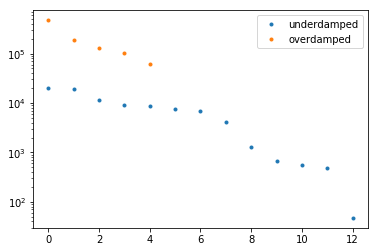

In [51]:
plt.plot(underdamped_msm_gt.timescales(), '.', label='underdamped')
plt.plot(overdamped_msm_gt.timescales(), '.', label='overdamped')
plt.legend(loc='best')
plt.yscale('log')

In [52]:
max(overdamped_msm_gt.timescales()) / max(underdamped_msm_gt.timescales())

23.22895846341496

In [53]:
int(max(overdamped_msm_gt.timescales())), int(max(underdamped_msm_gt.timescales()))

(473245, 20373)

<Container object of 14 artists>

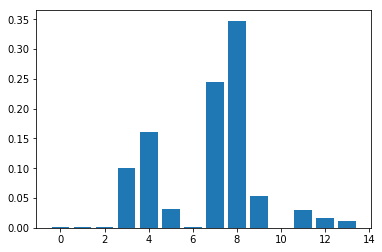

In [54]:
plt.bar(np.arange(len(underdamped_msm_gt.pi)), underdamped_msm_gt.pi)

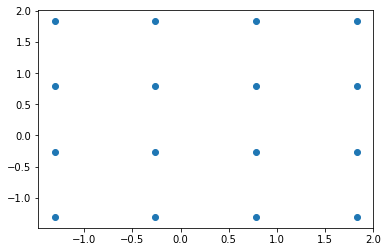

In [55]:
plt.scatter(initial_conditions[:,0], initial_conditions[:,1])#, c=underdamped_msm_gt.pi)

In [ ]:
# let's look at implied timescales as function of lagtime for overdamped and underdamped...



In [65]:
len(underdamped_dtrajs[0])

10000

In [74]:
lags = np.unique(np.array(np.round(np.logspace(0,4)), dtype=int))[:-1]
lags

array([   1,    2,    3,    4,    5,    7,    8,   10,   12,   14,   17,
         20,   24,   29,   36,   43,   52,   63,   75,   91,  110,  133,
        160,  193,  233,  281,  339,  409,  494,  596,  720,  869, 1048,
       1265, 1526, 1842, 2223, 2683, 3237, 3907, 4715, 5690, 6866, 8286])

In [71]:
underdamped_its = pyemma.msm.its(underdamped_dtrajs, lags=lags, nits=10, show_progress=False)

22-03-18 12:08:39 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[3] WARNING  Ignoring lag times that exceed the longest trajectory: [10000]


HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM: '),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=44), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

TypeError: refresh() got an unexpected keyword argument 'nolock'

In [ ]:
overdamped_its = pyemma.msm.its(overdamped_dtrajs, lags=lags, nits=10)

In [ ]:
underdamped_its = pyemma.msm.its(underdamped_dtrajs, lags=np.arange(1,100), nits=10)

In [72]:
len(underdamped_dtrajs)

800

In [78]:
from msmbuilder.msm import implied_timescales

underdamped_its = implied_timescales(underdamped_dtrajs, lag_times=lags)
overdamped_its = implied_timescales(overdamped_dtrajs, lag_times=lags)

MSM contains 3 strongly connected components above weight=1.00. Component 0 selected, with population 99.990712%
MSM contains 3 strongly connected components above weight=0.50. Component 0 selected, with population 99.990723%
MSM contains 3 strongly connected components above weight=0.33. Component 0 selected, with population 99.990735%
MSM contains 3 strongly connected components above weight=0.25. Component 0 selected, with population 99.990746%
MSM contains 3 strongly connected components above weight=0.20. Component 0 selected, with population 99.990758%
MSM contains 3 strongly connected components above weight=0.14. Component 0 selected, with population 99.990781%
MSM contains 3 strongly connected components above weight=0.12. Component 0 selected, with population 99.990793%
MSM contains 3 strongly connected components above weight=0.10. Component 0 selected, with population 99.990816%
MSM contains 3 strongly connected components above weight=0.08. Component 0 selected, with popul

MSM contains 18 strongly connected components above weight=0.00. Component 0 selected, with population 94.730341%
MSM contains 25 strongly connected components above weight=0.00. Component 0 selected, with population 94.736705%
MSM contains 26 strongly connected components above weight=0.00. Component 0 selected, with population 94.742211%
MSM contains 26 strongly connected components above weight=0.00. Component 0 selected, with population 94.747054%
MSM contains 27 strongly connected components above weight=0.00. Component 0 selected, with population 94.753191%
MSM contains 28 strongly connected components above weight=0.00. Component 0 selected, with population 94.760989%
MSM contains 34 strongly connected components above weight=0.00. Component 0 selected, with population 94.708844%
MSM contains 34 strongly connected components above weight=0.00. Component 0 selected, with population 94.719075%
MSM contains 34 strongly connected components above weight=0.00. Component 0 selected, w

In [80]:
overdamped_its.shape

(44, 10)

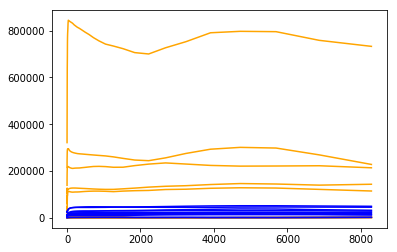

In [93]:
for i in range(overdamped_its.shape[1]):
    plt.plot(lags, overdamped_its[:,i], color='orange')
for i in range(underdamped_its.shape[1]):
    plt.plot(lags, underdamped_its[:,i], color='blue')

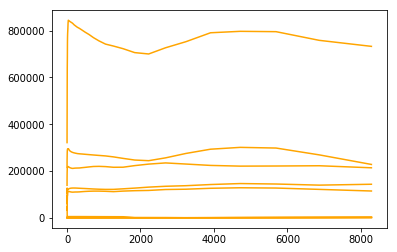

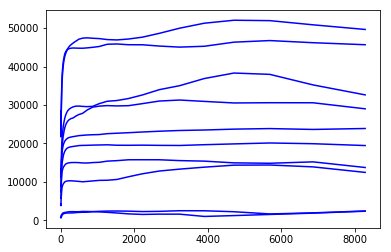

In [94]:
for i in range(overdamped_its.shape[1]):
    plt.plot(lags, overdamped_its[:,i], color='orange')
plt.figure()
for i in range(underdamped_its.shape[1]):
    plt.plot(lags, underdamped_its[:,i], color='blue')

In [29]:
plt.plot(lags, overdamped_its[:,0] / underdamped_its[:,0])

NameError: name 'lags' is not defined

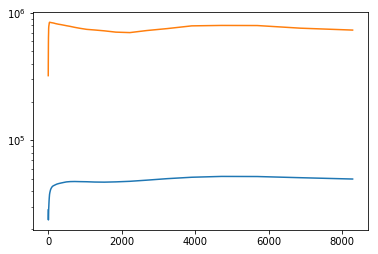

In [91]:
plt.plot(lags, underdamped_its[:,0])
plt.plot(lags, overdamped_its[:,0])

plt.yscale('log')

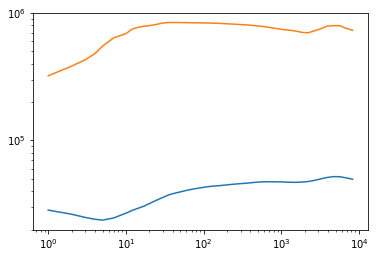

In [92]:
plt.plot(lags, underdamped_its[:,0])
plt.plot(lags, overdamped_its[:,0])

plt.yscale('log')
plt.xscale('log')

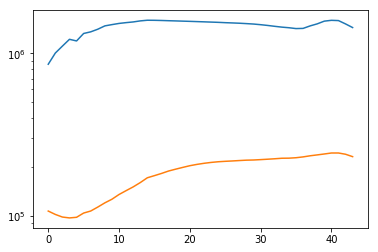

In [99]:
plt.plot(np.sum(overdamped_its, 1))
plt.plot(np.sum(underdamped_its, 1))
plt.yscale('log')

In [100]:
lags

array([   1,    2,    3,    4,    5,    7,    8,   10,   12,   14,   17,
         20,   24,   29,   36,   43,   52,   63,   75,   91,  110,  133,
        160,  193,  233,  281,  339,  409,  494,  596,  720,  869, 1048,
       1265, 1526, 1842, 2223, 2683, 3237, 3907, 4715, 5690, 6866, 8286])